# Introduction

According to [Globocan 2020][globocan], breast cancer was the most prevalent form of cancer, accounting for **2,261,419** (11.7%) of the **19,292,789** reported cases. Lung cancer was second with **2,206,771** cases (11.4%). 

Early diagnosis of cancer is crucial in ensuring the best chances of recovery, and a lot of research has been geared towards harnessing *machine learning* to help detect cancer faster and at scale.

## Aim / Purpose

- *To create a machine learning model that can predict the presence and type of lung cancer, given histopathological images.*

This effort is part of the [KaggleX BIPOC Mentorship Program][bipoc]. I'm glad to be a mentee in the second cohort, building skills in computer vision.

[globocan]: https://gco.iarc.fr/today/data/factsheets/cancers/39-All-cancers-fact-sheet.pdf
[bipoc]: https://www.kaggle.com/kagglex-bipoc-mentorship-program/


## Data Source

Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019.

The dataset consists of 25,000 images:

- 15,000 of lung cancer:
  - 5000 no cancer
  - 5000 adenocarcinoma
  - 5000 squamous cell carcinoma
- 10,000 of colon cancer:
  - 5000 no cancer
  - 5000 adenocarcinoma

## Caveat / Disclaimer

The dataset was derived from 1,250 (250 x 5) originals through image augmentation. There is thus [data leakage][data-leak], since some images will likely appear in both the training and validation sets. Model evaluation results will therefore not be reliable.

[data-leak]: https://www.kaggle.com/code/alexisbcook/data-leakage

> _"All images were cropped to square sizes of 768 x 768 pixels from
original 1024 x 768 pixels using the python programming language.
Subsequently, images were augmented using the Augmentor
software package. Augmentor is an image augmentation library in
Python for machine learning."_
>
> _"Using Augmentor, we expanded our dataset to 25,000 images by the
following augmentations: left and right rotations (up to 25 degrees,
1.0 probability) and by horizontal and vertical flips (0.5
probability)."_

<https://arxiv.org/pdf/1912.12142v1.pdf>

<https://github.com/tampapath/lung_colon_image_set/issues/5>



In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [2]:
BATCH_SIZE = 10
DATA_DIR = ("/kaggle/input/lung-and-colon-cancer-histopathological-images/"
            "lung_colon_image_set/colon_image_sets")
IMG_SIZE = 256
MAX_EPOCHS = 10
class_names = ["colon_n", "colon_aca"]
class_details = ["Adenocarcinoma", "No Cancer"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


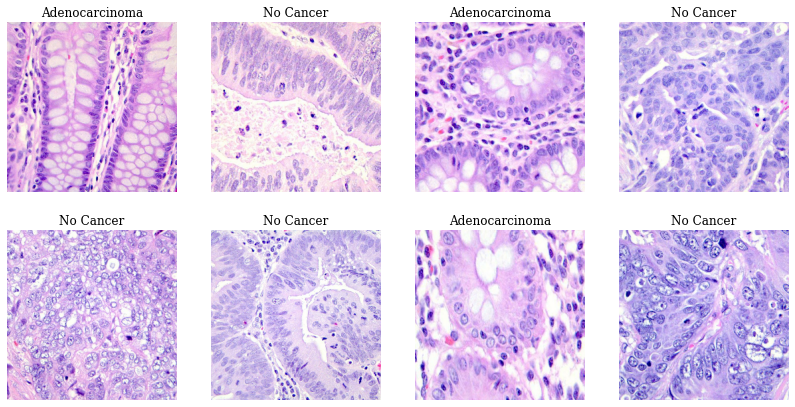

In [3]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [4]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Model with VGG16 base

In [5]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 14,780,739
Trainable params: 66,051
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/10
800/800 [==============================] - 42s 43ms/step - loss: 0.0620 - accuracy: 0.9824 - val_loss: 0.0770 - val_accuracy: 0.9830
Epoch 2/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 0.0469 - val_accuracy: 0.9875
Epoch 3/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0106 - val_accuracy: 0.9965
Epoch 4/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.0099 - val_accuracy: 0.9975
Epoch 5/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 0.2247 - val_accuracy: 0.9660
Epoch 6/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0110 - accuracy: 0.9971 - val_loss: 0.0071 - val_accuracy: 0.9980
Epoch 7/10
800/800 [==============================] - 32s 40ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.0235 - val_accuracy:

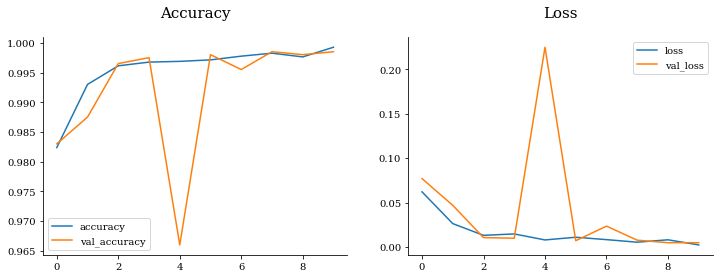

In [6]:
vgg16_history = compile_and_fit_model(vgg16_model)

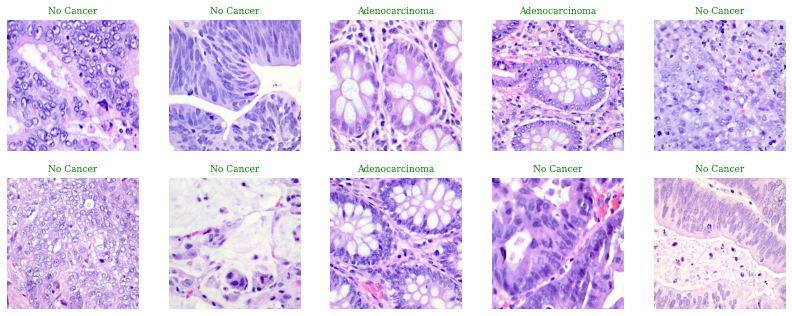

In [7]:
plot_predictions(vgg16_model)

# Model with ResNet50 base

In [8]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
resnet_model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 23,827,459
Trainable params: 262,659
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = compile_and_fit_model(resnet_model)

Epoch 1/10
800/800 [==============================] - 31s 35ms/step - loss: 0.0280 - accuracy: 0.9893 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 2/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 7.1110e-04 - val_accuracy: 1.0000
Epoch 3/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0143 - val_accuracy: 0.9950
Epoch 4/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 5/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 6/10
800/800 [==============================] - 27s 34ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 7/10
315/800 [==========>...................] - ETA: 13s - loss: 5.8362e-05 - accuracy: 1.0000

In [ ]:
plot_predictions(resnet_model)

# Model with EfficientNetB1 base

In [ ]:
prerained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

In [12]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

800/800 [==============================] - 29s 36ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 4/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0120 - accuracy: 0.9973 - val_loss: 0.0111 - val_accuracy: 0.9950
Epoch 5/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 6/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 2.7316e-04 - val_accuracy: 1.0000
Epoch 7/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0073 - accuracy: 0.9970 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 8/10
800/800 [==============================] - 29s 36ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 6.0507e-04 - val_accuracy: 1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



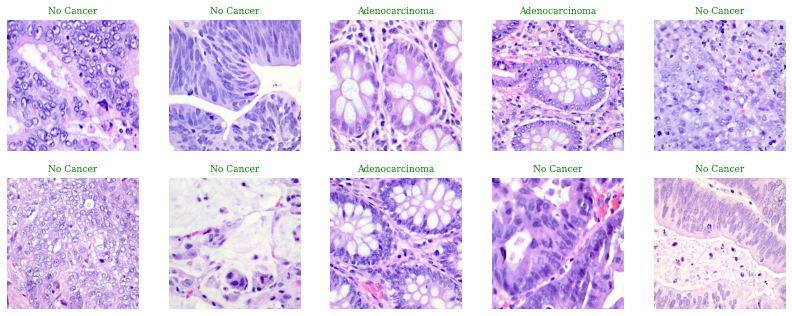

In [13]:
plot_predictions(efficientnet_model)

# Conclusion

The model with the *EfficientNet* base would be the natural choice here, since it is both performant and efficient(lightweight).

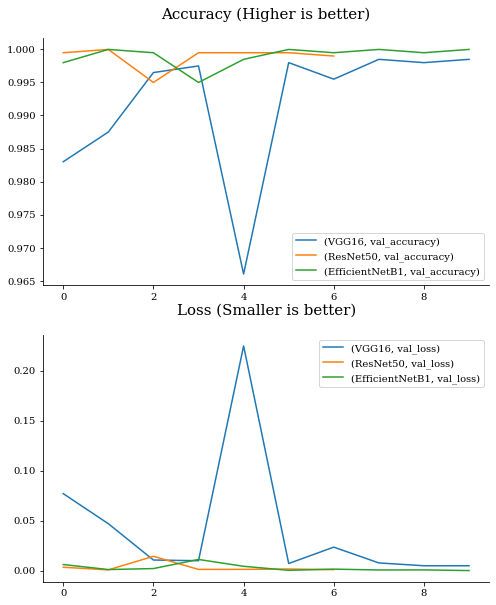

In [14]:
vgg_df = pd.DataFrame(vgg16_history.history)
resnet_df = pd.DataFrame(resnet_history.history)
efficientnet_df = pd.DataFrame(efficientnet_history.history)
combined = pd.concat([vgg_df, resnet_df, efficientnet_df], axis=1,
                     keys=["VGG16", "ResNet50", "EfficientNetB1"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
combined.filter(like="val_accuracy").plot(ax=ax1)
combined.filter(like="val_loss").plot(ax=ax2)
ax1.set_title("Accuracy (Higher is better)", size=15, pad=20)
ax1.legend(title="")
ax2.set_title("Loss (Smaller is better)", size=15, pad=20)
_ = ax2.legend(title="")

Due to the data leakage issue discussed earlier, we cannot reliably estimate how well these models would perform on real-world data. It would be unwise to deploy such models, and so we'll stop here.